In [1]:
import os
# Check if the kaggle.json file is in the correct location
os.makedirs('/root/.kaggle', exist_ok=True)
!mv kaggle.json /root/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

mv: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [2]:
!kaggle datasets download -d jeffheaton/demand-forecasting-with-tabular-textual-images

Dataset URL: https://www.kaggle.com/datasets/jeffheaton/demand-forecasting-with-tabular-textual-images
License(s): CC-BY-SA-4.0
 97% 122M/126M [00:01<00:00, 67.1MB/s]
100% 126M/126M [00:01<00:00, 84.9MB/s]


In [3]:
import zipfile
with zipfile.ZipFile('/content/demand-forecasting-with-tabular-textual-images.zip', 'r') as zip_ref:
    zip_ref.extractall()

In [4]:
import numpy as np
import pandas as pd

In [5]:
df_sales=pd.read_csv('/content/beach_demand_forecast/sales_train.csv')
df_restraunt=pd.read_csv('/content/beach_demand_forecast/resturants.csv')
df_items=pd.read_csv('/content/beach_demand_forecast/items.csv')

In [62]:
import plotly.express as px

df_plot = df_sales[['date','item_count']].groupby(['date']).sum().reset_index()
fig = px.line(df_plot, x="date", y="item_count", title='Total Sales by Date')
fig.show()

In [7]:
! pip install prophet

In [8]:
df_plot.columns = ['ds','y']

In [9]:
df_plot['ds'] = pd.to_datetime(df_plot['ds'])
df_plot = df_plot.set_index('ds').resample('D').sum().reset_index()

In [10]:
from sklearn.model_selection import train_test_split


In [11]:
split_index = int(0.8 * len(df_plot))

# Split the data
train_data = df_plot[:split_index]
test_data = df_plot[split_index:]

In [12]:
from prophet import Prophet

In [63]:
model = Prophet(daily_seasonality=True)
# Add yearly seasonality
# model.add_seasonality(name='yearly', period=365.25, fourier_order=2)

model.fit(train_data)

DEBUG:cmdstanpy:input tempfile: /tmp/tmp17wgn_6c/7tocx03e.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp17wgn_6c/ivdurgbx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=5407', 'data', 'file=/tmp/tmp17wgn_6c/7tocx03e.json', 'init=/tmp/tmp17wgn_6c/ivdurgbx.json', 'output', 'file=/tmp/tmp17wgn_6c/prophet_modeldo0u06gm/prophet_model-20241218181827.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:18:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:18:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [64]:
future = test_data[['ds']].copy()

In [65]:
future

,ds
876,2021-05-26
877,2021-05-27
878,2021-05-28
879,2021-05-29
880,2021-05-30
...,...
1091,2021-12-27
1092,2021-12-28
1093,2021-12-29
1094,2021-12-30


In [66]:
print(future.isnull().sum())

ds    0
dtype: int64


In [67]:
future['ds']=pd.to_datetime(future['ds'])

In [95]:
forecast = model.predict(future)

In [96]:
forecast['yhat']

,yhat
0,783.126107
1,958.040512
2,1078.156014
3,1082.708103
4,658.626975
...,...
215,313.184570
216,374.768107
217,431.070074
218,605.508649


In [97]:
result = test_data.copy()

In [98]:
result['y']

,y
876,746.0
877,967.0
878,1117.0
879,1073.0
880,617.0
...,...
1091,192.0
1092,344.0
1093,371.0
1094,527.0


In [99]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2021-05-26,550.086135,731.656634,838.430891,550.086135,550.086135,233.039972,233.039972,233.039972,117.85088,...,-66.041950,-66.041950,-66.041950,181.231042,181.231042,181.231042,0.0,0.0,0.0,783.126107
1,2021-05-27,550.181366,904.595502,1006.980100,550.181366,550.181366,407.859146,407.859146,407.859146,117.85088,...,107.764889,107.764889,107.764889,182.243376,182.243376,182.243376,0.0,0.0,0.0,958.040512
2,2021-05-28,550.276597,1025.473895,1131.153676,550.276597,550.276597,527.879416,527.879416,527.879416,117.85088,...,226.811070,226.811070,226.811070,183.217466,183.217466,183.217466,0.0,0.0,0.0,1078.156014
3,2021-05-29,550.371829,1031.091244,1139.416746,550.371829,550.371829,532.336275,532.336275,532.336275,117.85088,...,230.320404,230.320404,230.320404,184.164990,184.164990,184.164990,0.0,0.0,0.0,1082.708103
4,2021-05-30,550.467060,603.000573,714.376765,550.467060,550.467060,108.159915,108.159915,108.159915,117.85088,...,-194.786969,-194.786969,-194.786969,185.096004,185.096004,185.096004,0.0,0.0,0.0,658.626975
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
215,2021-12-27,570.560868,253.281163,364.252878,566.515424,574.821596,-257.376299,-257.376299,-257.376299,117.85088,...,-182.430798,-182.430798,-182.430798,-192.796381,-192.796381,-192.796381,0.0,0.0,0.0,313.184570
216,2021-12-28,570.656100,320.609511,429.682742,566.592342,574.960206,-195.887993,-195.887993,-195.887993,117.85088,...,-121.636647,-121.636647,-121.636647,-192.102227,-192.102227,-192.102227,0.0,0.0,0.0,374.768107
217,2021-12-29,570.751331,378.275727,483.711786,566.663820,575.078310,-139.681257,-139.681257,-139.681257,117.85088,...,-66.041950,-66.041950,-66.041950,-191.490188,-191.490188,-191.490188,0.0,0.0,0.0,431.070074
218,2021-12-30,570.846562,554.688472,657.017646,566.725788,575.200429,34.662086,34.662086,34.662086,117.85088,...,107.764889,107.764889,107.764889,-190.953683,-190.953683,-190.953683,0.0,0.0,0.0,605.508649


In [100]:
len(result)

220

In [101]:
len(forecast)

220

In [102]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
mae = mean_absolute_error(result['y'], forecast['yhat'])
mse = np.sqrt(mean_squared_error(result['y'], forecast['yhat']))

In [103]:
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {mse}")

Mean Absolute Error (MAE): 45.10344667096267
Root Mean Squared Error (RMSE): 56.82708238054011


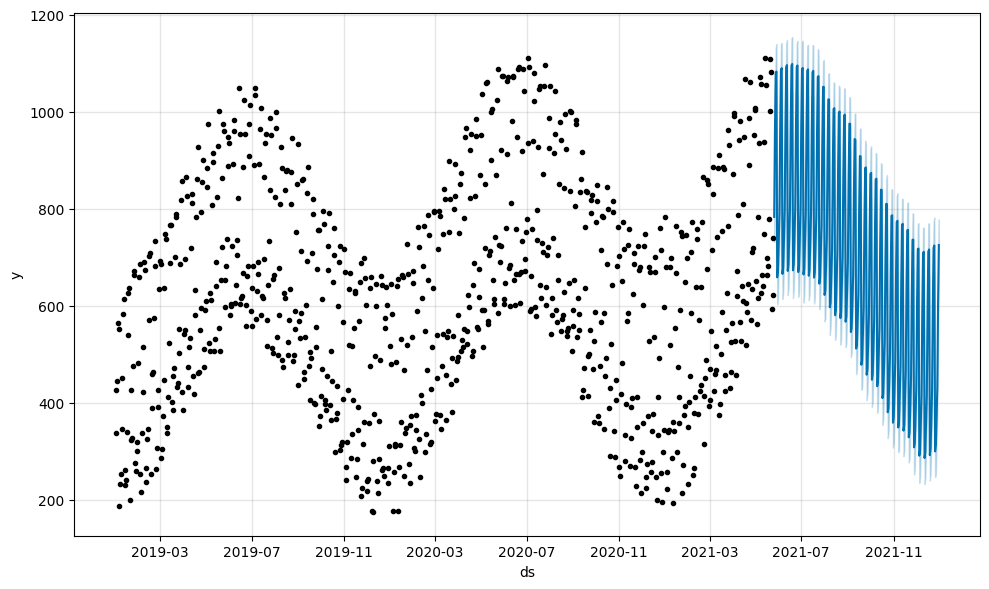

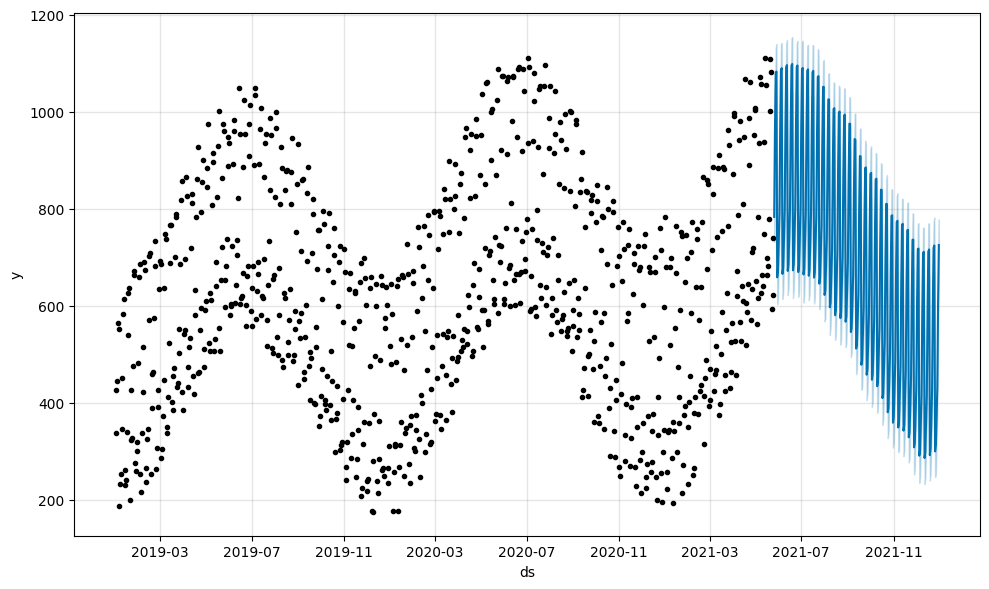

In [104]:
model.plot(forecast)

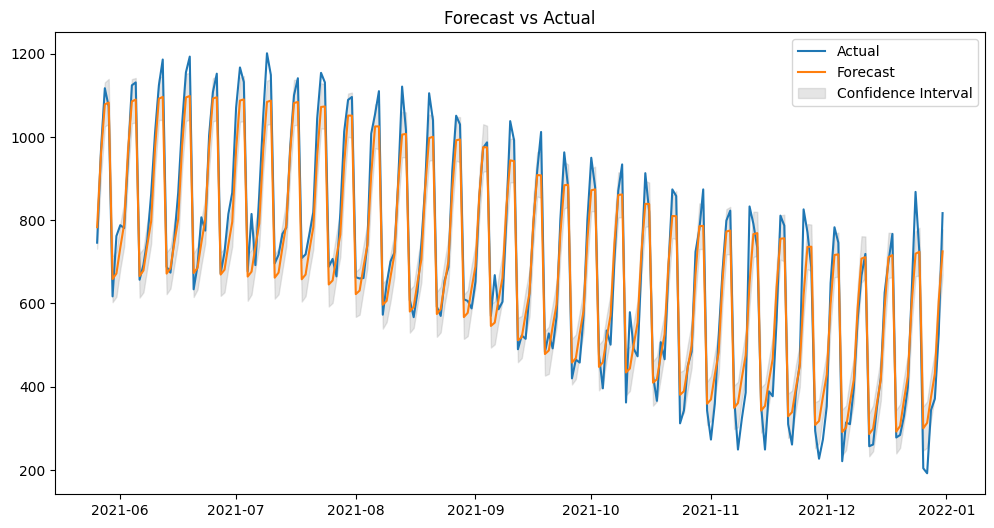

In [105]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(test_data['ds'], test_data['y'], label='Actual')
plt.plot(forecast['ds'], forecast['yhat'], label='Forecast')
plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='gray', alpha=0.2, label='Confidence Interval')
plt.legend()
plt.title('Forecast vs Actual')
plt.show()

In [106]:
train_data

,ds,y
0,2019-01-01,427.0
1,2019-01-02,337.0
2,2019-01-03,445.0
3,2019-01-04,564.0
4,2019-01-05,552.0
...,...,...
871,2021-05-21,1108.0
872,2021-05-22,1082.0
873,2021-05-23,594.0
874,2021-05-24,623.0


In [108]:
test_data.index

RangeIndex(start=876, stop=1096, step=1)

In [112]:
forecast=forecast.set_index(test_data.index)

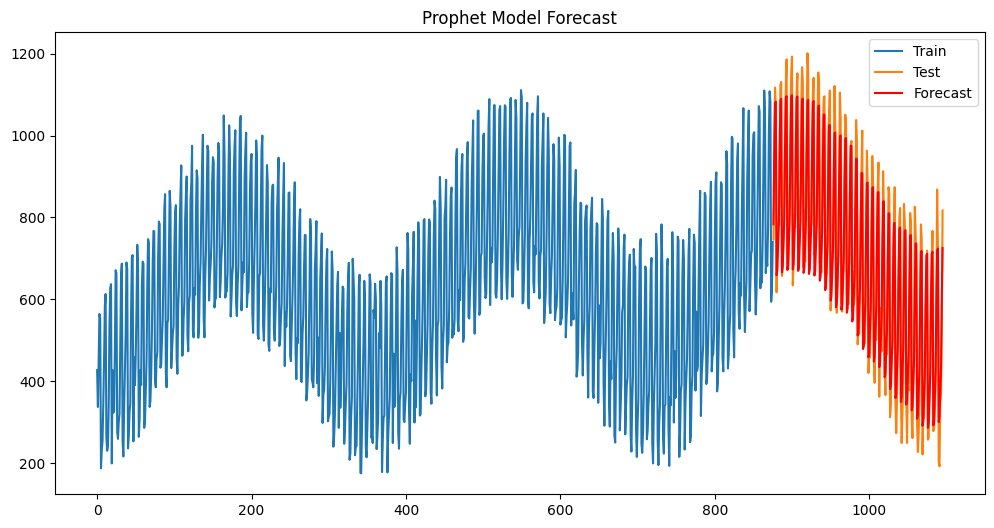

In [113]:

plt.figure(figsize=(12, 6))
plt.plot(train_data['y'], label='Train')
plt.plot(test_data['y'], label='Test')
plt.plot(forecast['yhat'], label='Forecast', color='red')
plt.legend()
plt.title('Prophet Model Forecast')
plt.show()

In [94]:
test_data['y']

,y
876,746.0
877,967.0
878,1117.0
879,1073.0
880,617.0
...,...
1091,192.0
1092,344.0
1093,371.0
1094,527.0
